<a href="https://colab.research.google.com/github/vijaygwu/SEAS8525/blob/main/Chap_2_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Setup
The code starts by importing necessary libraries:
- `matplotlib.pyplot` for visualization
- `numpy` for numerical operations
- `tensorflow` and related modules for deep learning
- MobileNetV2 and preprocessing functions for transfer learning

## Data Loading and Processing
The code loads the TensorFlow 'tf_flowers' dataset, which contains images of flowers. It splits the data:
- 70% for training
- 15% for validation
- 15% for testing

The `prep` function processes each image by:
1. Resizing it to 160×160 pixels
2. Applying MobileNetV2's preprocessing (normalization to [-1,1] range)

The dataset pipeline includes:
- Shuffling training data (with buffer size 1024)
- Mapping the preprocessing function
- Batching with size 32
- Prefetching for performance optimization

## Data Visualization
The `show_batch` function displays a grid of sample images from the dataset:
- Takes the first batch from the dataset
- Creates a 3×3 grid of images
- De-normalizes the images (from [-1,1] to [0,1]) for proper display
- Labels each image with its flower class name
- Displays the grid

## Model Architecture
The model uses transfer learning with MobileNetV2:
1. Loads pre-trained MobileNetV2 (trained on ImageNet) without its top classification layer
2. Freezes the base model weights (`base.trainable = False`)
3. Adds custom classification layers:
   - Global Average Pooling to reduce spatial dimensions
   - Dropout (20%) for regularization
   - A Dense layer with softmax activation for multi-class classification

The model is compiled with:
- Adam optimizer
- Sparse categorical cross-entropy loss (appropriate for integer labels)
- Accuracy metric

## TensorBoard Setup
The code sets up TensorBoard logging:
- Creates a file writer for logging to the "logs/images" directory
- Defines a callback function to log validation images each epoch
- Creates callbacks for both image logging and general TensorBoard metrics

## Training
The model is trained for 30 epochs with:
- The training dataset
- Validation against the validation dataset
- TensorBoard callbacks for monitoring

## Evaluation
Finally, the model is evaluated on the test dataset, and its accuracy is printed.

This is a standard transfer learning approach where:
1. A powerful pre-trained model (MobileNetV2) does the feature extraction
2. Custom classification layers are trained on these features for the specific flower classification task



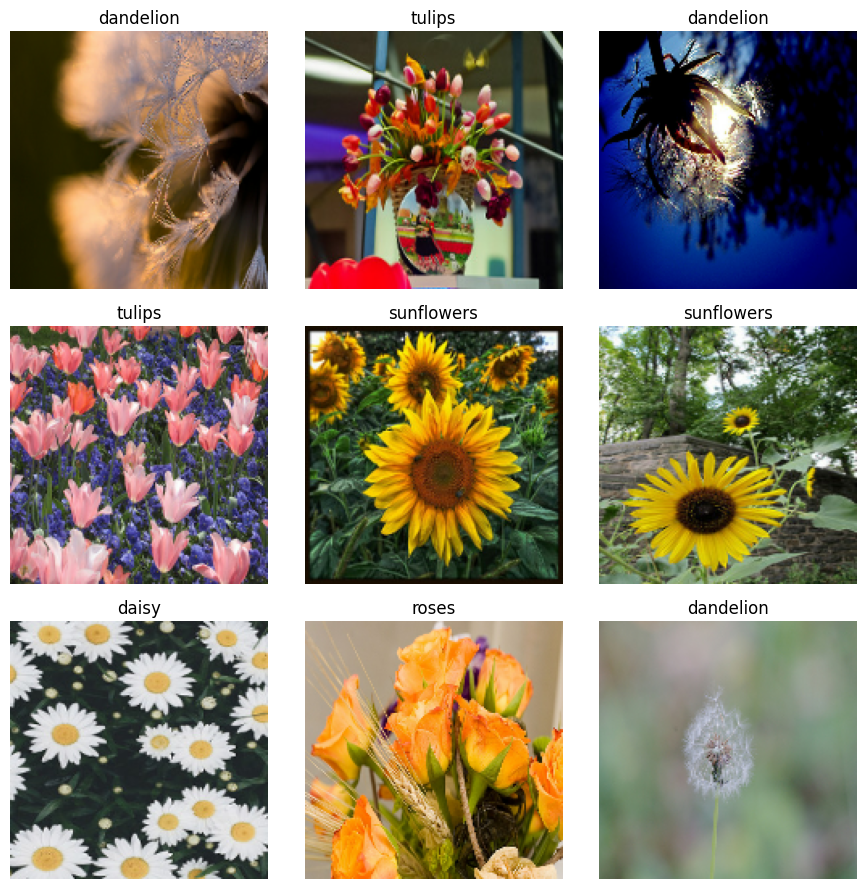

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 118ms/step - acc: 0.5146 - loss: 1.2187 - val_acc: 0.8330 - val_loss: 0.4779
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - acc: 0.8602 - loss: 0.4240 - val_acc: 0.8675 - val_loss: 0.3806
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - acc: 0.8864 - loss: 0.3417 - val_acc: 0.8766 - val_loss: 0.3335
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - acc: 0.9033 - loss: 0.2979 - val_acc: 0.8820 - val_loss: 0.3281
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - acc: 0.9176 - loss: 0.2428 - val_acc: 0.8802 - val_loss: 0.3171
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - acc: 0.9305 - loss: 0.2184 - val_acc: 0.8820 - val_loss: 0.3113
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - acc: 0.9437 - loss: 0.1764 - val_acc: 0.8820 - val_loss: 0.2956
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - acc: 0.9484 - loss: 0.1700 - val_acc: 0.8875 - val_loss: 0.2959
Epoch 9/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - acc: 0.95

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# ---------- data ----------------------------------------------------
IMG_SIZE, BATCH = (160, 160), 32
splits = ['train[:70%]', 'train[70%:85%]', 'train[85%:]']
(train_ds, val_ds, test_ds), info = tfds.load(
    'tf_flowers', split=splits, with_info=True, as_supervised=True
)
class_names = info.features['label'].names          # ['daisy', …]

def prep(img, lab):
    img = tf.image.resize(img, IMG_SIZE)
    return preprocess_input(img), lab

ds = lambda d, sh=False: d.shuffle(1024) if sh else d
train_ds = ds(train_ds, True).map(prep).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = ds(val_ds      ).map(prep).batch(BATCH).prefetch(tf.data.AUTOTUNE)
test_ds  = ds(test_ds     ).map(prep).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# ---------- 🔍 show first batch -------------------------------------
def show_batch(dataset, n=9):
    imgs, labels = next(iter(dataset))
    imgs, labels = imgs[:n], labels[:n]
    plt.figure(figsize=(9, 9))
    for i in range(n):
        plt.subplot(int(np.sqrt(n)), int(np.sqrt(n)), i+1)
        plt.imshow((imgs[i].numpy() + 1) / 2)     # de-normalize MobileNet scale
        plt.title(class_names[labels[i]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_batch(train_ds)      # comment out once you’ve verified

# ---------- model ---------------------------------------------------
base = MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base.trainable = False
inputs  = layers.Input(shape=IMG_SIZE + (3,))
x       = base(inputs, training=False)
x       = layers.GlobalAveragePooling2D()(x)
x       = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model   = models.Model(inputs, outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# ---------- 📸 TensorBoard images every epoch -----------------------
logdir = "logs/images"
file_writer = tf.summary.create_file_writer(logdir)

def log_images(epoch, logs):
    imgs, labs = next(iter(val_ds))
    with file_writer.as_default():
        tf.summary.image("val-batch", (imgs[:16] + 1) / 2, step=epoch, max_outputs=16)

tb_img_cb = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_images)
tb_cb     = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

# ---------- train ---------------------------------------------------
model.fit(train_ds,
          epochs=30,
          validation_data=val_ds,
          callbacks=[tb_img_cb, tb_cb])

# ---------- test ----------------------------------------------------
print("Test acc:", model.evaluate(test_ds)[1])
